# Measuring activation fronts near death
Tim Tyree<br>
5.7.2021

In [1]:
#TODO: use google scholar to search for the speed of spiral tips as they annihilate

#better method: take more data! (after condensing data to a simple readout)
#DONE/DONT(later): look for more reliable way to identify activation fronts... use consistency of position over time??
# HINT: consider looking at mean gating variables from the comp_dict_topo_full_color
#TODO: linearly record data for ^these spiral tips at a high sampling rate (and fine spatial resolution)

#TODO(brainwarmer): check Slides for whether tips move along dVdt levelsets or along V levelsets
#TODO: load/plot system
#TODO: compute each of the the final scalar values needed for the following...
#TODO: test angular difference between cartesion acceleration and acceleration in the direction of the activation front versus time
#TODO: linearly track lesser_arclen of these two death events on a dt=0.001 ms timescale fixed at the basic subpixel resolution
#TODO: test proposition that lesser_arclen always drops shortly annihilating, perhaps on the 0.01~0.02 (ms?) timescale.  
# ^This would support the mechanism of annihilation involving the connection of activation fronts/strings with some tension to contract
# ^This would support using a model of spiral tip dynamics along an activation front to inform our reaction rate calculations
# HINT: consider rate = 1/expected_time_to_death, where the arclength behaves in a predictable way, i.e.
# dsigma_max_dt=foo(sigma_max;relative phase?)

# Compute the spacing between two tips as they annihilate (Luo-Rudy model)

In [1]:
from lib.my_initialization import *
# from lib.controller.controller_LR import get_one_step_explicit_synchronous_splitting
# from lib.utils import load_buffer
# from lib.routines.return_min_distance import *
# from lib.viewer.DomainPlot import ShowDomain
# from lib.measure.comp_tips_safely import *
from lib import *

#my_initialization.py
import pandas as pd, numpy as np, matplotlib.pyplot as plt

#load the libraries
# from .utils.operari import *
#automate the boring stuff
# from IPython import utils
import time, os, sys, re
import dask.bag as db
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Automatic calling is: Smart


In [36]:
dt=0.001
diffCoef=0.0005
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_200.0.npz'
t0=200.0;t=t0
txt=load_buffer(txt_fn)[0]
# txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
# t0=218.8;t=t0

# txt=load_buffer(txt_fn)
ds=5.;V_threshold=-50.
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
print(txt.shape)
one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=V_threshold,jump_threshold=40,nb_dir=nb_dir)
comp_dict_topo_full_color=comp_dict_tips
# #instantaneous method of spiral tip detection
# #reidentify the tips to be tracked
# img=inVc[...,0];dimgdt=dVcdt[...,0]
# dict_tips=comp_dict_tips(img, dimgdt, t, txt)
# pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
# t_prev=t;txt_prev=txt.copy()

(200, 200, 18)


In [42]:
_,_,one_step=get_one_step_explicit_synchronous_splitting(
    nb_dir,
    dt=dt,
    width=width,
    height=height,
    ds=ds,
    diffCoef=diffCoef,
    Cm=1.0)
one_step

CPUDispatcher(<function get_one_step_explicit_synchronous_splitting.<locals>.one_step_explicit_synchronous_splitting at 0x7f1d3ed60b90>)

In [43]:
#integrate ic forward before measuring tips
DT=2
nsteps=int(DT/(dt))
txt_prev=txt.copy()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
t_prev=t
for n in range ( nsteps ):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
t+=dt*nsteps
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [44]:
#lagged method of spiral tip detection
comp_dict_topo_instant=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0.)
comp_dict_topo_lagged=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=V_threshold)
img=txt[...,0].T;img_prev=txt_prev[...,0]
dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)
pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy()

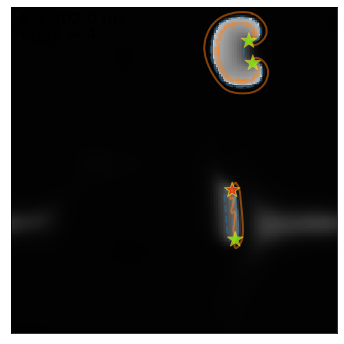

In [56]:
#visualize token death system
x_values=np.array(dict_tips['x'])#[:-2]
y_values=np.array(dict_tips['y'])#[:-2]
c_values=np.array(dict_tips['pid'])#[:-2]
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                 fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]])

In [57]:
# from inspect import getsource
# print ( getsource(pdict.record_tips_return_txt))
# pdict.record_tips_return_txt?
ntips=len(dict_tips['x'])
assert(ntips>0)

In [58]:
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# while there are still tips,
save_every_n_frames=1
nsteps=1
# img=txt[...,0];img_prev=txt_prev[...,0]
# dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)
img_item_lst=[]
# ntips=len(dict_tips['x'])
while ntips>0:
    #extract images
    img=inVc[...,0].copy()#;dimgdt=dVcdt[...,0]
    img_item_lst.append((t,img))
    #recall img_prev, which is voltage at a time DT earlier
    t_a,img_prev=img_item_lst[0]
    DT_img_item_lst=t-t_a
    if DT_img_item_lst>=DT:
        #record tips
        img_item_lst.pop(0)
        txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
        dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)
#         dict_tips=comp_tips(img,img_prev,dimgdt, t, txt)
        ntips=len(dict_tips['x'])
        if ntips>0:
            pdict.merge(dict_tips)
            # t_prev=t;txt_prev=txt.copy();
#         frameno=SaveTipsAndColoredContours(img,frameno,dict_tips,save_folder=save_folder)#,save_fn=None,vmin_img=-85.,vmax_img=35.,inch=5)
        print(f"saved ntips={ntips}, time={t:.2f} ms.", end='\r')

    for j in range(save_every_n_frames):
        #integrate forward by one_step
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt

txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

In [ ]:
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# frameno=0
# save_every_n_frames=1
# # while change_time<=duration:
# while ntips>0:
#     frameno+=1
#     t+=dt
#     one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
#     if frameno % save_every_n_frames == 0:
#         dict_tips=comp_dict_tips(img, dimgdt, t, txt)
#         pdict.merge_dict(dict_tips)
#         ntips=len(dict_tips['x'])
#         print(f"saved at time {t:.3f} ms.",end='\r')

# txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)

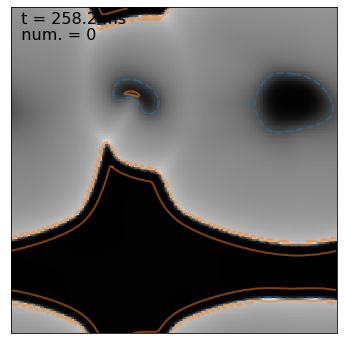

In [61]:
#visualize token death system
img=inVc[...,0].copy();dimgdt=dVcdt[...,0]
x_values=np.array(dict_tips['x'])#[:-2]
y_values=np.array(dict_tips['y'])#[:-2]
c_values=np.array(dict_tips['pid'])#[:-2]
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                 fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]])

In [63]:
#format/save output pdict
modname=f"{nb_dir}/Data/test_data/steady_death_test_LR_t0_{t0:.3f}_t_{t:.3f}_DT_0.001"
pdict.to_csv_and_json(modname)

{0: (size,t,x,y)=(1,202.000,135.815,87.757);,
 1: (size,t,x,y)=(1,202.000,137.699,57.506);,
 2: (size,t,x,y)=(1,202.000,146.113,179.384);,
 3: (size,t,x,y)=(15816,219.814,168.998,146.888);,
 4: (size,t,x,y)=(54192,258.192,75.993,144.200);,
 5: (size,t,x,y)=(23152,227.151,85.000,138.406);,
 6: (size,t,x,y)=(15815,219.814,169.009,146.883);,
 7: (size,t,x,y)=(19,219.609,175.009,146.421);,
 8: (size,t,x,y)=(19,219.609,174.981,146.412);,
 9: (size,t,x,y)=(86,219.817,171.892,146.001);,
 10: (size,t,x,y)=(86,219.817,171.911,145.998);,
 11: (size,t,x,y)=(136,227.151,85.000,138.404);,
 12: (size,t,x,y)=(31176,258.192,76.004,144.194);}

# Compute the spacing between two tips as they annihilate (Fenton-Karma model)

In [1]:
from lib.my_initialization import *
# from lib.controller.controller_LR import get_one_step_explicit_synchronous_splitting
# from lib.utils import load_buffer
from lib.routines.return_min_distance import *
from lib.viewer.DomainPlot import ShowDomain
from lib.utils.dist_func import *
from lib.utils.utils_jsonio import *
from lib.model.minimal_model_cuda import *
from lib.measure.utils_measure_tips_cpu import fetch_txt_to_tip_dict
from lib.model.minimal_model import *
from lib.controller.controller_cuda import *
from lib.model.minimal_model_cuda import get_kernel_string_FK_model
from lib.measure.full_color_contours import *
from lib.utils import load_buffer

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Automatic calling is: Smart


In [2]:
#load initial conditions interactively
#find file interactively
# print("please select a file from within the desired folder.")
# input_file_name = search_for_file()
input_file_name='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-in/ic_200x200.001.31.npz'
ic = load_buffer(input_file_name)
txt=ic.copy()
diffCoef=0.0005
dt=0.0005
ds=5.;V_threshold=0.4
dsdpixel=ds/500

height, width, channel_no = ic.shape
zero_txt = np.zeros((width, height, channel_no), dtype=np.float64)

# _,comp_distance,_=init_methods(width,height,ds,dt,V_threshold=V_threshold,jump_threshold=40)

#map initial condition to the three initial scalar fields
u_initial = np.array(ic.astype(np.float64)[...,0])
v_initial = np.array(ic.astype(np.float64)[...,1])
w_initial = np.array(ic.astype(np.float64)[...,2])

t=0.;
#load parameters for parameter set 8 for the Fenton-Karma Model
param_file_name = '/home/timothytyree/Documents/GitHub/care/notebooks/lib/model/param_set_8.json'
kwargs = read_parameters_from_json(param_file_name)
kwargs['diffCoef']=diffCoef
kernel_string = get_kernel_string_FK_model(**kwargs, DT=dt,DX=0.025,height=height,width=width)

#more initialization
param_fn=param_file_name
param_dir = os.path.join(nb_dir,'lib/model')
param_dict = json.load(open(os.path.join(param_dir,param_fn)))
if diffCoef is not None:
    param_dict['diffCoef']=diffCoef
#cpu jit compiled one_step method (may be needed for current tip obs. method...)
get_time_step=fetch_get_time_step(width,height,DX=dsdpixel,DY=dsdpixel,**param_dict)

comp_dict_topo_instant=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=0.)
comp_dict_topo_lagged=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=V_threshold)

# update_with_full_color_observations=get_update_with_full_color_observations(width=200.,height=200.)
# update_with_full_color_observations(dict_topo,contours1,contours2,txt)

# # # one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=V_threshold,jump_threshold=40)
# # comp_dict_topo_full_color=comp_dict_tips
# #reidentify the tips to be tracked
# dtxt_dt = zero_txt.copy()
# get_time_step(txt, dtxt_dt)
# img=txt[...,0];dimgdt=dtxt_dt[...,0]
# dict_tips=comp_dict_tips(img, dimgdt, t, txt)
# pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
# t_prev=t;txt_prev=txt.copy()

In [3]:
#initializing cuda context
#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#define how resources are used
# width  = kwargs['width']
# height = kwargs['height']
threads = (10,10,1)
grid = (int(width/10), int(height/10), 1)
block_size_string = "#define block_size_x 10\n#define block_size_y 10\n"

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

one_step_map=get_one_step_map(time_step_kernel, drv, u_new, u_old, v_new, v_old, w_new, w_old, threads, grid, context)
# one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=V_threshold,jump_threshold=40)
# comp_dict_topo_full_color=comp_dict_tips


#integrate ic forward before measuring tips
tf=800.
DT=2
nsteps=int(DT/(2*dt))
while t<=tf:
    txt_prev=txt.copy()
    txt=one_step_map(txt,nsteps=nsteps)
    t+=2*dt*nsteps

In [7]:
t

1452.0

In [5]:
# txt_prev=txt.copy()
# txt=one_step_map(txt,nsteps=nsteps)

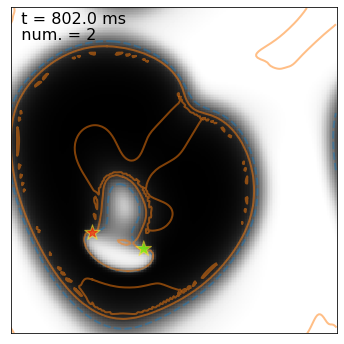

In [4]:
V_threshold=0.4#0.7#0.1#0.5#0.4

#reidentify the tips to be tracked, safely
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)
dimgdt=dtxt_dt[...,0];
img=txt[...,0];img_prev=txt_prev[...,0]
dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)

# comp_tips=get_comp_tips(width,height,V_threshold)


#TODO: add any fields from either dict for comp_tips
# dict_tips=comp_tips(img,img_prev,dimgdt,t,txt)
# dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)


pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)
ntips=len(dict_tips['x'])

#visualize token death system
x_values=np.array(dict_tips['x'])
y_values=np.array(dict_tips['y'])
c_values=np.array(dict_tips['pid'])
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,
                 inch=6,fontsize=16,vmin_img=0.,vmax_img=1.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]])

In [ ]:
#TODO(later): get comp_tips_safely working
# dict_tips=comp_tips(img,img_prev,dimgdt,t,txt)
# dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)

In [7]:
t0=t

In [5]:
# from inspect import getsource
# print ( getsource(pdict.record_tips_return_txt))
# pdict.record_tips_return_txt?
ntips=len(dict_tips['x'])
assert(ntips>0)

In [6]:
# while there are still tips,
save_every_n_frames=1
nsteps=1
# img=txt[...,0];img_prev=txt_prev[...,0]
# dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)
img_item_lst=[]
# ntips=len(dict_tips['x'])
while ntips>0:
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()
    #compute images
    img=txt[...,0].copy()#;dimgdt=dVcdt[...,0]
    img_item_lst.append((t,img))
    #recall img_prev, which is voltage at a time DT earlier
    t_a,img_prev=img_item_lst[0]
    DT_img_item_lst=t-t_a
    if DT_img_item_lst>=DT:
        #record tips
        img_item_lst.pop(0)
        dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)
#         dict_tips=comp_tips(img,img_prev,dimgdt, t, txt)
        ntips=len(dict_tips['x'])
        if ntips>0:
            pdict.merge(dict_tips)
            # t_prev=t;txt_prev=txt.copy();
#         frameno=SaveTipsAndColoredContours(img,frameno,dict_tips,save_folder=save_folder)#,save_fn=None,vmin_img=-85.,vmax_img=35.,inch=5)
        print(f"saved ntips={ntips}, time={t:.2f} ms.", end='\r')

    for j in range(save_every_n_frames):
        #     integrate forward by one_step
        #         one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        #         t+=dt
        txt=one_step_map(txt,nsteps=nsteps)
        t+=2*dt*nsteps


In [10]:
pdict

{0: (size,t,x,y)=(94644,898.643,59.991,49.582);,
 1: (size,t,x,y)=(94644,898.643,60.026,49.566);}

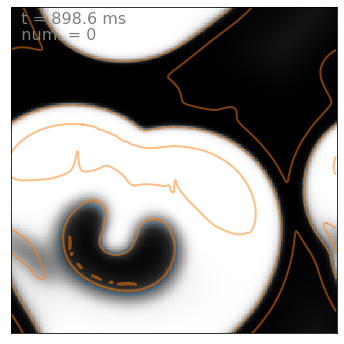

In [15]:
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)
dimgdt=dtxt_dt[...,0];

img=txt[...,0];
t_a,img_prev=img_item_lst[0]
# img_prev=txt_prev[...,0]
dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)

#visualize token death system
x_values=np.array(dict_tips['x'])
y_values=np.array(dict_tips['y'])
c_values=np.array(dict_tips['pid'])
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,
                 inch=6,fontsize=16,vmin_img=0.,vmax_img=1.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]],textcolor='gray')

In [11]:
#formatsave output pdict
modname=f"{nb_dir}/Data/test_data/steady_death_test_FK_t0_{t0:.3f}_t_{t:.3f}_DT_0.001"
pdict.to_csv_and_json(modname)

{0: (size,t,x,y)=(94644,898.643,59.991,49.582);,
 1: (size,t,x,y)=(94644,898.643,60.026,49.566);}

In [23]:
#integrate forward a bit more...
tf=100.
DT=2
nsteps=int(DT/(2*dt))
while t<=tf:
    txt_prev=txt.copy()
    txt=one_step_map(txt,nsteps=nsteps)
    t+=2*dt*nsteps

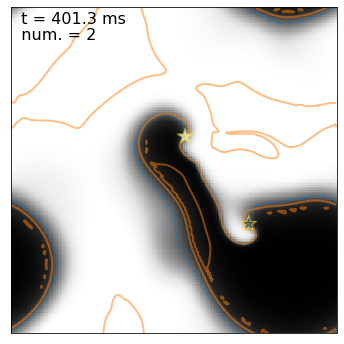

In [27]:
#view/screenshot a snapshot of domain. does it look reasonable?
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)
dimgdt=dtxt_dt[...,0];

img=txt[...,0];img_prev=txt_prev[...,0]
# t_a,img_prev=img_item_lst[0]
# img_prev=txt_prev[...,0]
dict_tips=comp_dict_topo_lagged(img, img_prev, t, txt)

#visualize token death system
x_values=np.array(dict_tips['x'])
y_values=np.array(dict_tips['y'])
c_values=np.array(dict_tips['pid'])
kwargs={'text_color':'black'}#:'white'}
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,
                 inch=6,fontsize=16,vmin_img=0.,vmax_img=1.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]],**kwargs)

# Analysis

## plots of the results of the last living tip as it annihilates with the other last living tip

In [16]:
savemodname='fine-death-termination-FK'

# savemodname='fine-death-FK'
savefig_folder=f"{nb_dir}/Figures/fine_death"
if not os.path.exists(savefig_folder):
    os.mkdir(savefig_folder)

In [17]:
#import df from ^that modname
pid_alive_lst=pdict.get_alive_particles()
pid=pid_alive_lst[0]
# pid=0
#OR separate pdict directly without saving
df, dict_greater_dict, dict_lesser_dict=pdict.separate_data_to_pandas()

In [18]:
from jupyterthemes import jtplot
jtplot.style(context='notebook', ticks=True, grid=False)

In [19]:
#DONE: translated these functions into ParticleDictPBC methods
def compute_field_values(pdict,field,):
    pid_lst=pdict.get_alive_particles()
    last_particle=pdict[pid_lst[0]]
    values=np.array(last_particle[field])
    return values

def compute_t_values(pdict,pid=None,ds=5.,field='t',**kwargs):
    if pid is None:
        pid_lst=pdict.get_alive_particles()
        particle=pdict[pid_lst[0]]
    else:
        particle=pdict[pid]
    scale=1.#ms per ms
    t_values=scale*np.array(particle[field])
    return t_values


def compute_sigma_max_values(pdict,pid=None,ds=5.,field='lesser_arclen',**kwargs):
    if pid is None:
        pid_lst=pdict.get_alive_particles()
        particle=pdict[pid_lst[0]]
    else:
        particle=pdict[pid]
    scale=ds/particle.width #cm/pixel
    sigma_max_values=scale*np.array(particle[field])
    return sigma_max_values

In [20]:
print("are all the fields required for the entire analysis present? what about 'lesser_xy_values'?")
pdict[0].keys()

are all the fields required for the entire analysis present? what about 'lesser_xy_values'?


dict_keys(['x', 'y', 't', 'lesser_pid', 'lesser_arclen', 'greater_pid', 'greater_arclen'])

In [21]:
# greater_mean_V_values=compute_field_values(pdict,field='greater_mean_V')
# lesser_mean_V_values=compute_field_values(pdict,field='lesser_mean_V')
# greater_mean_curvature_values=compute_field_values(pdict,field='greater_mean_curvature')
# lesser_mean_curvature_values=compute_field_values(pdict,field='lesser_mean_curvature')
# pdict[0].keys()

In [41]:
#compute sigma_max as a function of time 
t_values=compute_t_values(pdict,pid=pid,ds=ds,field='t')
sigma_max_lesser_values=compute_sigma_max_values(pdict,pid=pid,ds=ds)
sigma_max_greater_values=compute_sigma_max_values(pdict,pid=pid,ds=ds,field='greater_arclen')
# from inspect import getsource
# print ( getsource(compute_last_sigma_max))
x_values=t_values[-1]-t_values
y_values=sigma_max_lesser_values

	time between two frames was 0.001 ms
saved figure in 
	fine-death-termination-FK-arclen.png


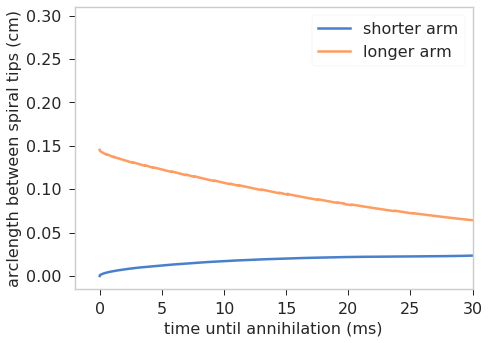

In [34]:
fontsize=16
#plot naive range at death and birth
plt.subplots(figsize=(7,5))
plt.plot(x_values,sigma_max_lesser_values,label='shorter arm',c='C0',lw=2.5,alpha=0.9)
plt.plot(x_values,sigma_max_greater_values,label='longer arm',c='C4',lw=2.5,alpha=0.9)
plt.xlabel('time until annihilation (ms)',fontsize=fontsize)
plt.ylabel('arclength between spiral tips (cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xlim([-2,30])
# plt.xlim([1e-3,30])
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=1)
print(f"\ttime between two frames was {0.001} ms")

saving=True
savefig_fn=savemodname+f"-arclen.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

	time between two frames was 0.001 ms
saved figure in 
	fine-death-termination-FK-arclen-log.png


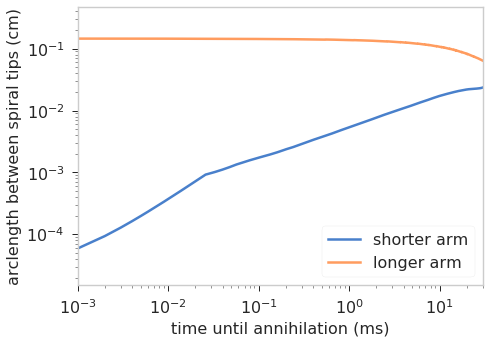

In [35]:
fontsize=16
#plot naive range at death and birth
plt.subplots(figsize=(7,5))
plt.plot(x_values,sigma_max_lesser_values,label='shorter arm',c='C0',lw=2.5,alpha=0.9)
plt.plot(x_values,sigma_max_greater_values,label='longer arm',c='C4',lw=2.5,alpha=0.9)
plt.xlabel('time until annihilation (ms)',fontsize=fontsize)
plt.ylabel('arclength between spiral tips (cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.xlim([-2,30])
plt.xlim([1e-3,30])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=1)
print(f"\ttime between two frames was {0.001} ms")

saving=True
# savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=savemodname+f"-arclen-log.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [36]:
#compute the loglog slope at short times
boo=(x_values<0.01)&(x_values>0.)
# boo=(x_values<0.05)&(x_values>0.)
y_values=sigma_max_lesser_values
y=y_values[boo]
x=x_values[boo]

os.chdir(nb_dir)
# !pwd

from lib.measure.powerlaw import *
print_fit_power_law(x,y)

compute_95CI_ols(np.log(x),np.log(y))

m=0.810829+-0.035995; B=0.005876+-0.000215
M= 0.015527+--0.002223 Hz*cm^{2(m-1)}
RMSE=0.0000 Hz/cm^2
R^2=0.9961


{'m': 0.8108294275718475,
 'Delta_m': 0.03599528931405383,
 'b': -4.207189479255912,
 'Delta_b': 0.19588380546346304,
 'Rsquared': 0.9960739672490307}

In [44]:
#compute the loglog slope at slightly longer times
boo=(x_values<10.)&(x_values>0.1)
y_values=sigma_max_lesser_values
y=y_values[boo]
x=x_values[boo]

os.chdir(nb_dir)
# !pwd

from lib.measure.powerlaw import *
print_fit_power_law(x,y)

compute_95CI_ols(np.log(x),np.log(y))

m=0.508529+-0.000105; B=0.000034+-0.000000
M= 0.005341+--0.000005 Hz*cm^{2(m-1)}
RMSE=0.0001 Hz/cm^2
R^2=0.9999


{'m': 0.5085292337597225,
 'Delta_m': 0.00010548345446131008,
 'b': -5.228046950488538,
 'Delta_b': 0.0001702077626707099,
 'Rsquared': 0.999893542059265}

## measure voltage and curvature of activation front during annihilation 
supposes activation front it the shorter arm

NameError: name 'lesser_mean_curvature_values' is not defined

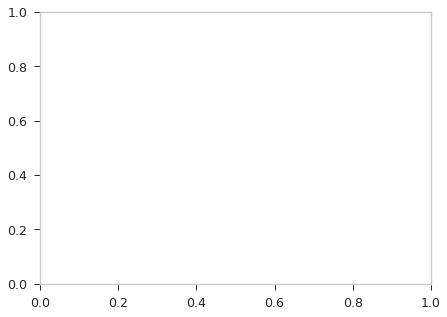

In [49]:
fontsize=16
#plot naive range at death and birth
plt.subplots(figsize=(7,5))#(5,4))
plt.plot(x_values[1:],lesser_mean_curvature_values,label='shorter arm',c='C0',lw=2.5,alpha=0.9)
plt.plot(x_values[1:],greater_mean_curvature_values,label='longer arm',c='C4',lw=2.5,alpha=0.9)
plt.xlabel('time until annihilation (ms)',fontsize=fontsize)
plt.ylabel('mean curvature (1/cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim([1e0,1e9])
plt.xlim([-2,30])
# plt.xlim([1e-3,30])
# plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=1)
# print(f"\ttime between two frames was {0.001} ms")

saving=True
# savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=savemodname+f"-curvature.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
    plt.close()

NameError: name 'lesser_mean_curvature_values' is not defined

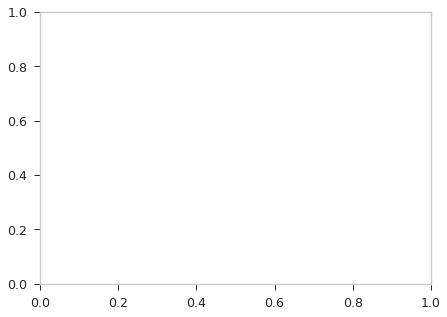

In [50]:
fontsize=16
#plot naive range at death and birth
plt.subplots(figsize=(7,5))#(5,4))
plt.plot(x_values[1:],lesser_mean_curvature_values,label='shorter arm',c='C0',lw=2.5,alpha=0.9)
plt.plot(x_values[1:],greater_mean_curvature_values,label='longer arm',c='C4',lw=2.5,alpha=0.9)
plt.xlabel('time until annihilation (ms)',fontsize=fontsize)
plt.ylabel('mean curvature (1/cm)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim([1e0,1e9])
# plt.xlim([-2,30])
plt.xlim([1e-3,30])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=1)
# print(f"\ttime between two frames was {0.001} ms")

saving=True
# savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=savemodname+f"-curvature-log.png"
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

NameError: name 'lesser_mean_V_values' is not defined

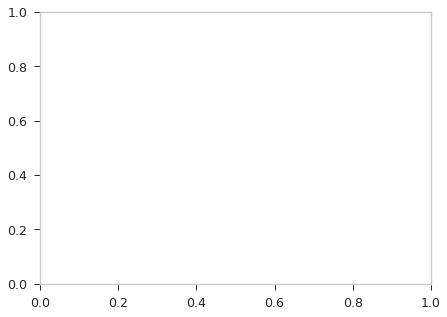

In [51]:
fontsize=16
#plot naive range at death and birth
plt.subplots(figsize=(7,5))#(5,4))
plt.plot(x_values[1:],lesser_mean_V_values,label='shorter arm',c='C0',lw=2.5,alpha=0.9)
plt.plot(x_values[1:],greater_mean_V_values,label='longer arm',c='C4',lw=2.5,alpha=0.9)
plt.xlabel('time until annihilation (ms)',fontsize=fontsize)
plt.ylabel('voltage (mV)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.ylim([1e0,1e9])
plt.xlim([-2,30])
# plt.xlim([1e-3,30])
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=1)
# print(f"\ttime between two frames was {0.001} ms")

saving=True
# savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=savemodname+f"-voltage.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

NameError: name 'lesser_mean_V_values' is not defined

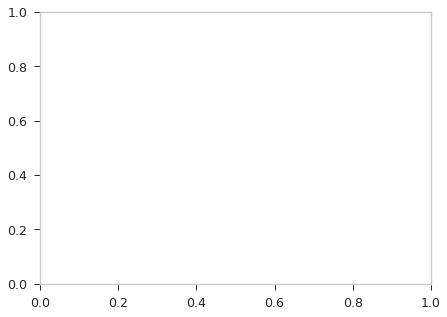

In [52]:
fontsize=16
#plot naive range at death and birth
plt.subplots(figsize=(7,5))#(5,4))
plt.plot(x_values[1:],lesser_mean_V_values,label='shorter arm',c='C0',lw=2.5,alpha=0.9)
plt.plot(x_values[1:],greater_mean_V_values,label='longer arm',c='C4',lw=2.5,alpha=0.9)
plt.xlabel('time until annihilation (ms)',fontsize=fontsize)
plt.ylabel('mean voltage (mV)',fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.ylim([1e0,1e9])
# plt.xlim([-2,30])
plt.xlim([1e-3,30])
plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=1)
# print(f"\ttime between two frames was {0.001} ms")

saving=True
# savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=savemodname+f"-voltage-log.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [53]:
# fontsize=16
# #plot naive range at death and birth
# plt.subplots(figsize=(7,5))#(5,4))
# boo=x_values[1:]<8

# plt.scatter(lesser_mean_curvature_values[boo],lesser_mean_V_values[boo],label='shorter arm',c='C0',alpha=0.5)
# plt.scatter(greater_mean_curvature_values[boo],greater_mean_V_values[boo],label='longer arm',c='C4',alpha=0.5)
# plt.xlabel('mean curvature (1/cm)',fontsize=fontsize)
# plt.ylabel('electric potential (mV)',fontsize=fontsize)

# # plt.scatter(sigma_max_lesser_values[1:][boo],lesser_mean_V_values[boo],label='shorter arm',c='C0',lw=1.5,alpha=0.9)
# # plt.scatter(sigma_max_greater_values[1:][boo],greater_mean_V_values[boo],label='longer arm',c='C4',lw=1.5,alpha=0.9)
# # plt.xlabel('arclength between spiral tips (cm)',fontsize=fontsize)
# # plt.ylabel('electric potential (mV)',fontsize=fontsize)
# # plt.xlim([1e-3,1e-2])

# # plt.scatter(sigma_max_lesser_values[1:][boo],lesser_mean_curvature_values[boo],label='shorter arm',c='C0',lw=1.5,alpha=0.9)
# # plt.scatter(sigma_max_greater_values[1:][boo],greater_mean_curvature_values[boo],label='longer arm',c='C4',lw=1.5,alpha=0.9)
# # plt.xlabel('arclength between spiral tips (cm)',fontsize=fontsize)
# # plt.ylabel('mean curvature (1/cm)',fontsize=fontsize)

# plt.legend(fontsize=fontsize)
# # plt.ylim([1e-3,1e5])
# plt.xscale('log')
# # plt.yscale('log')
# plt.tick_params(axis='both', which='major', labelsize=fontsize)
# plt.tick_params(axis='both', which='minor', labelsize=1)
# plt.show()
# # print(f"\ttime between two frames was {0.001} ms")

In [54]:
#quantify force direction along activation front
#TODO: compute the 2D unit vector directed from the given particle along its lesser arclen
#TODO: compute the 2D unit vector directed in the direction the first particle position is moving
#TODO: compute the signed_angle = arcsin(cross product magnitude of ^those 2D unit vectors)
#TODO: visualize ^that angle versus time until death

In [55]:
#quantify effect of relative phase on reaction
#TODO: compute the 2D unit vector directed from the given particle along its lesser arclen
#TODO: compute the 2D unit vector directed from the first particle position to the second particle position
#TODO: compute the signed_angle = arcsin(cross product magnitude of ^those 2D unit vectors)
#TODO: visualize ^that angle versus time until death
# df.head()

Perhaps, each spiral tip is more like a local oscillator with a relative phase, $\phi_{i,j}(t)$, 
- given by the angle with the shortest line 

In [ ]:
#quantify form of relative phase on reaction
#TODO: compute ^that phase for both particles
#TODO: visualize a few measures that combine phi1 and phi2... phi2-phi1? phi2+phi1?
# QUESTION: Is there a clear pattern that removes the need for the displacement vector, xy2-xy1?
# QUESTION: if so, what ODE might describe the time evolution of this relative phase measure?

In [ ]:
i=7 #ith time frame
greater_dict=dict_greater_dict[pid]
XY=np.array(greater_dict['greater_xy_values'])
X,Y=XY[i].T
Z=np.array(greater_dict['greater_xy_values'])[i]

In [ ]:
# Y=greater_dict['y_values']
contours = plt.contour(X, Y, Z, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.imshow(Z, extent=[0, 5, 0, 5], origin='lower',
           cmap='RdGy', alpha=0.5)
plt.colorbar();
greater_dict=dict_greater_dict[pid]

greater_dict.keys()

In [ ]:
# # plot sigma_max of the lesser_arclen versus time for all particles, centering about their last recorded time
# fontsize=18
# # saving=True
# # savefig_folder=f"{nb_dir}/Figures"
# # savefig_fn=f"arclen-versus-ttdeath-2.png"
# figsize=(6,5)
# fig,ax=plt.subplots(figsize=figsize)

# pid_lst=list(pdict.keys())
# pid_lst=pdict.get_alive_particles()

# # pid_lst=pdict.get_alive_particles()
# for pid in pid_lst[:1]:
#     #extract values
#     sigma_max_values=np.array(pdict[pid]['greater_arclen'])
#     sigma_max_values_other=np.array(pdict[pid]['lesser_arclen'])
#     t_values=np.array(pdict[pid]['t'])
#     t_until_death_values=t_values[-1]-t_values
#     x_values=t_until_death_values
#     y_values=sigma_max_values*5/img.shape[0]
#     y_values_other=sigma_max_values_other*5/img.shape[0]
    
#     #plot values
#     ax.scatter(x_values,y_values,alpha=0.2)
#     ax.scatter(x_values,y_values_other,alpha=0.2)
# #format
# ax.set_xlim([8e-3,2e1])
# ax.set_ylim([1e-2,10])
# ax.set_xlabel('time until annihilation (ms)', fontsize=fontsize)
# ax.set_ylabel('arclength of\nactivation front (cm)', fontsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.set_xscale('log')
# ax.set_yscale('log')

# # saving=True
# # savefig_folder=f"{nb_dir}/Figures"
# # savefig_fn=f"arclen-versus-ttdeath-2.png"
# # if not saving: 
# #     plt.show() 
# # else:
# #     plt.tight_layout()
# #     os.chdir(savefig_folder)
# #     plt.savefig(savefig_fn, dpi=300)
# #     print(f"saved figure in \n\t{savefig_fn}")
# #     plt.close()

## measure distance between spiral tips that annihilate

In [27]:
from lib.measure.relative_phases import *
from lib.measure.relative_phases import get_compute_ranges_between
compute_ranges_between=get_compute_ranges_between(width=width,height=height)

pdict

{0: (size,t,x,y)=(94644,898.643,59.991,49.582);,
 1: (size,t,x,y)=(94644,898.643,60.026,49.566);}

In [37]:
#compute the pdict
ds=5.
df, dict_greater_dict, dict_lesser_dict=pdict.separate_data_to_pandas()

#extract the relevant particles/contour
pid_pair=pdict.get_alive_particles()
# pid=pid_pair[0]
# pid_deathmate=pdict[pid]['lesser_pid'][-1]
# # pid=0
# # pid_deathmate=1
# pid_pair=pid,pid_deathmate
d1=df[df.pid==float(pid_pair[0])].copy()
d2=df[df.pid==float(pid_pair[1])].copy()
dict_activation_front=dict_lesser_dict[pid_pair[0]]
# dict_activation_front=dict_greater_dict[pid_pair[0]]

#time values
t1_values=d1['t'].values
t2_values=d2['t'].values
if t2_values.shape[0]<t1_values.shape[0]:
    t_values=t2_values.copy()
else:
    t_values=t1_values.copy()
# try:
#     t_values=np.array(dict_activation_front['t'])[1:]
# except TypeError as e:
#     t_values=t1_values

In [38]:
#compute range_values directly between particles (with periodic bc)
range_values=compute_ranges_between(d1,d2)

#compute xy values
t_death_values=t_values[-1]-t_values
arclen_values=sigma_max_lesser_values
x_values=t_death_values
y_values=range_values*ds/width

saved figure in 
	fine-death-termination-FK-death-range.png


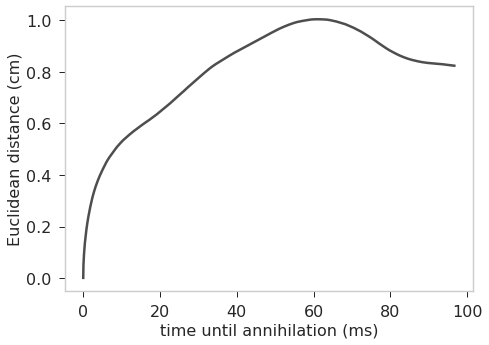

In [30]:
fontsize=16
#plot naive range at death and birth
plt.subplots(figsize=(7,5))#(5,4))
plt.plot(x_values,y_values,c='k',alpha=0.8,lw=2.5)
# plt.scatter(x_values,range_values*5/200,c='k',alpha=0.5)
# plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
plt.xlabel('time until annihilation (ms)',fontsize=fontsize)
plt.ylabel('Euclidean distance (cm)',fontsize=fontsize)

# plt.legend(fontsize=fontsize)
# plt.xlim([1e-3,30])
# plt.ylim([1e-4,0.6])
# plt.ylim([1e-3,1e5])
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=1)
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")


saving=True
# savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=savemodname+f"-death-range.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

saved figure in 
	fine-death-termination-FK-range-log.png


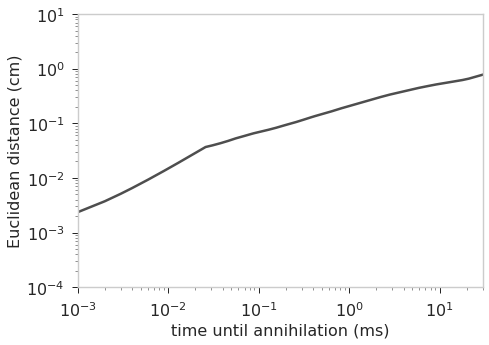

In [31]:
fontsize=16
#plot naive range at death and birth
plt.subplots(figsize=(7,5))#(5,4))

plt.plot(x_values,y_values,c='k',alpha=0.8,lw=2.5)
# plt.scatter(x_values,range_values*5/200,c='k',alpha=0.5)
# plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
plt.xlabel('time until annihilation (ms)',fontsize=fontsize)
plt.ylabel('Euclidean distance (cm)',fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.xlim([1e-3,30])
plt.ylim([1e-4,1e1])
# plt.ylim([1e-3,1e5])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=1)
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=True
# savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=savemodname+f"-range-log.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [39]:
#compute the loglog slope at short times
boo=(x_values<0.01)&(x_values>0.)
# boo=(x_values<0.05)&(x_values>0.)
y=y_values[boo]
x=x_values[boo]

os.chdir(nb_dir)
# !pwd

from lib.measure.powerlaw import *
print_fit_power_law(x,y)

compute_95CI_ols(np.log(x),np.log(y))

m=0.810828+-0.035995; B=0.555030+-0.020284
M= 0.620418+-0.005737 Hz*cm^{2(m-1)}
RMSE=0.0004 Hz/cm^2
R^2=0.9961


{'m': 0.810827947489269,
 'Delta_m': 0.035994968803105376,
 'b': -0.5193885685162432,
 'Delta_b': 0.19588206126566737,
 'Rsquared': 0.9960740226143393}

In [40]:
#compute the loglog slope at slightly longer times
boo=(x_values<10.)&(x_values>0.1)
y=y_values[boo]
x=x_values[boo]

os.chdir(nb_dir)
# !pwd

from lib.measure.powerlaw import *
print_fit_power_law(x,y)

compute_95CI_ols(np.log(x),np.log(y))

m=0.429160+-0.000724; B=0.022905+-0.000044
M= 0.197764+--0.000375 Hz*cm^{2(m-1)}
RMSE=0.0192 Hz/cm^2
R^2=0.9930


{'m': 0.42916021648666086,
 'Delta_m': 0.0007237880264944268,
 'b': -1.5759515852529506,
 'Delta_b': 0.0011679020303857317,
 'Rsquared': 0.9930108345315951}

## measure phase angles between last living spiral tips


$$
\text{Let   } \varphi_1\equiv\sin^{-1}\big(\widehat{\mathbf{x}_2-\mathbf{x}_1}\;\times\;\hat{\mathbf{a}}_1\big),
$$

$$
\text{and let   } \varphi_2\equiv\sin^{-1}\big(\widehat{\mathbf{x}_1-\mathbf{x}_2}\;\times\;\hat{\mathbf{a}}_2\big).
$$

plot the range/phase information for this death event

In [ ]:
#compute the relative phases of spiral tips
range_values,phi1_values,phi2_values=compute_phases_between(d1,d2,dict_activation_front,field='lesser_xy_values')
# range_values,phi1_values,phi2_values=compute_phases_between(d1,d2,dict_activation_front,field='greater_xy_values')
phi_sum_values, phi_diff_values=comp_relative_phase(phi1_values,phi2_values)

#print results
print(f"printing means...")
print(f"phi1   , phi2     = {np.mean(phi1_values):.3f},{np.mean(phi2_values):.3f} at time {np.mean(t_values):.3f}.")
print(f"phi_sum, phi_diff = {np.mean(phi_sum_values):.3f},{np.mean(phi_diff_values):.3f}.")

In [ ]:
#extract values for plot
sigma_max_lesser_values=compute_sigma_max_values(pdict,ds)
# sigma_max_greater_values=compute_sigma_max_values(pdict,ds,field='greater_arclen',pid=pid_pair[0])
x_values=(t_values[-1]-t_values)
# boo=x_values<8 #ms

y_values_lst=[phi1_values,phi2_values,phi_sum_values, phi_diff_values]
y_label_lst=[r'$\phi_1$',r'$\phi_2$',r'$\phi_{sum}$',r'$\phi_{diff}$']
ax_lst=[0,0,1,1]
c_lst=['C0','C4','C0','C4']

In [ ]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,5))#(5,4))

for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
    ax=axs[nax]
    ax.plot(x_values[1:],y_values,alpha=1.0,label=y_label,c=color,lw=2.5)
    # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
    ax.set_xlabel('time until annihilation (ms)',fontsize=fontsize)
    ax.set_ylabel('signed phase (rad)',fontsize=fontsize)

    ax.set_xlim([1e-3,1e0])
    ax.set_ylim([-np.pi/8,np.pi/8])
    #     ax.set_xlim([1e-3,1e2])
    ax.set_xscale('log')
    # plt.yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=1)
    ax.legend(fontsize=fontsize)

plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")

saving=True
savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=f"fine-death-range-phase.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [ ]:
fontsize=16
#plot naive range at death and birth
fig,axs=plt.subplots(ncols=2,figsize=(12,5))#(5,4))

for y_values,y_label,nax,color in zip(y_values_lst,y_label_lst,ax_lst,c_lst):
    ax=axs[nax]
    ax.plot(x_values[1:],np.abs(y_values),alpha=1.0,label=y_label,c=color,lw=2.5)
    # plt.scatter(x_values[boo],range_values[boo],c='k',alpha=0.5,s=3)
    ax.set_xlabel('time until annihilation (ms)',fontsize=fontsize)
    ax.set_ylabel('absolute phase (rad)',fontsize=fontsize)

    ax.set_xlim([1e-3,1e0])
    ax.set_ylim([1e-6,np.pi/4])
    #     ax.set_xlim([1e-3,1e2])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=1)
    ax.legend(fontsize=fontsize)

plt.tight_layout()
# plt.show()
# print(f"\ttime between two frames was {0.001} ms")


saving=True
savefig_folder=f"{nb_dir}/Figures/fine_death"
savefig_fn=f"fine-death-phase-log.png"
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

## save a snapshot and highlight the activation front

In [ ]:
dt=0.001
txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_218.8.npz'
t=218.8;ds=5.;V_threshold=-50.
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
print(txt.shape)
one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=V_threshold,jump_threshold=40)
comp_dict_topo_full_color=comp_dict_tips
#reidentify the tips to be tracked
img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_tips=comp_dict_tips(img, dimgdt, t, txt)
# pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy()

#visualize token death system
x_values=np.array(dict_tips['x'])[:-2]
y_values=np.array(dict_tips['y'])[:-2]
c_values=np.array(dict_tips['pid'])[:-2]
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                 fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                 frameno=None,#frameno,
                 save_fn=None,#save_fn,
                 save_folder=None,#save_folder,
                 save=False,#True,
                 annotating=True,
                 axis=[0,img.shape[0],0,img.shape[1]])

## measure slopes on the log-log plot for arclength and range versus time as time goes to zero

In [59]:
t_death_values=t_values[-1]-t_values
arclen_values=sigma_max_lesser_values
x_values=t_death_values


#compute the loglog slope at short times
boo=(x_values<0.05)&(x_values>0.)

y=arclen_values[boo]
x=x_values[boo]

os.chdir(nb_dir)
# !pwd

from lib.measure.powerlaw import *
print_fit_power_law(x,y)

compute_95CI_ols(np.log(x),np.log(y))

m=1.001+-0.001; B=0.022+-0.000
M= 0.02+--0.00 Hz*cm^{2(m-1)}
RMSE=0.0000 Hz/cm^2
R^2=1.000


{'m': 1.0006927456603132,
 'Delta_m': 0.0014541770071421452,
 'b': -3.827345816060789,
 'Delta_b': 0.005894959948362418,
 'Rsquared': 0.9999751880935623}

In [ ]:
arclen_values=sigma_max_lesser_values
range_values,phi1_values,phi2_values=compute_phases_between(d1,d2,dict_activation_front,field='lesser_xy_values')
# range_values=range_values[1:]
x_values=t_death_values[1:]

#compute the loglog slope at short times
boo=(x_values<0.05)&(x_values>0.)

y=range_values[boo]
x=x_values[boo]

os.chdir(nb_dir)
# !pwd

from lib.measure.powerlaw import *
print_fit_power_law(x,y)

In [ ]:
y.shape==x.shape

In [ ]:
plt.plot(x,y)

# DONE: measure two tips collide in the FK model using gpu acceleration
- DONE: get comp_tips working with the FK model 
- zoom in for an annihilation event from the FK model
6.1.2021
- DONE: copy my cuda one_step method for the FK model
- DONE: import an ic
- DONE: identify a token FK death event where n=2 --> n=0
6.8.2021
- TODO: compute the distance between two tips versus time until death
- TODO: plot the distance between two tips versus time until death

In [ ]:
# heretim
from lib.utils.dist_func import *
from lib.utils.utils_jsonio import *
from lib.model.minimal_model_cuda import *
from lib.measure.utils_measure_tips_cpu import fetch_txt_to_tip_dict
from lib.model.minimal_model import *

from lib.controller.controller_cuda import *

#TODO:combine the LR observation method with the FK one_step method
#DONE: get one_step method working in cuda for fk model
#DONE: get tip detection working
#TODO: integrate up until just before death
#TODO: save texture as with the LR model
#TODO: integrate ^this with the existing routine
#TODO(to save time in finding a near death event): once there are 2 tips, save txt_prev

#load initial conditions interactively
#find file interactively
# print("please select a file from within the desired folder.")
# input_file_name = search_for_file()
input_file_name='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-in/ic_200x200.001.31.npz'
ic = load_buffer(input_file_name)

tme=0
plt.imshow(ic)
plt.title(f"t={tme}")
plt.show()

height, width, channel_no = ic.shape

#map initial condition to the three initial scalar fields
u_initial = np.array(ic.astype(np.float64)[...,0])
v_initial = np.array(ic.astype(np.float64)[...,1])
w_initial = np.array(ic.astype(np.float64)[...,2])

diffCoef=0.0005
ds=5
dsdpixel=ds/500
dt=0.001
t=0.;
ds=5.;V_threshold=0.4
#load parameters for parameter set 8 for the Fenton-Karma Model
param_file_name = '/home/timothytyree/Documents/GitHub/care/notebooks/lib/model/param_set_8.json'
kwargs = read_parameters_from_json(param_file_name)
kwargs['diffCoef']=diffCoef
kernel_string = get_kernel_string_FK_model(**kwargs, DT=dt,DX=0.025,height=height,width=width)

# #default observation parameters
# n = 50  #half the number of steps between observations of spiral tips
# nsteps = 10**6
# pad = 10
# edge_tolerance = 6
# atol = 1e-10
# printing=True

width, height, channel_no = ic.shape
zero_txt = np.zeros((width, height, channel_no), dtype=np.float64)
# nanstate = [np.nan,np.nan,np.nan]
# ycoord_mesh, xcoord_mesh = np.meshgrid(np.arange(0,width+2*(pad)),np.arange(0,width+2*pad))

param_fn=param_file_name
param_dir = os.path.join(nb_dir,'lib/model')
param_dict = json.load(open(os.path.join(param_dir,param_fn)))
if diffCoef is not None:
    param_dict['diffCoef']=diffCoef

get_time_step=fetch_get_time_step(width,height,DX=dsdpixel,DY=dsdpixel,**param_dict)

# print(kernel_string)

#initializing cuda context
#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#define how resources are used
# width  = kwargs['width']
# height = kwargs['height']
threads = (10,10,1)
grid = (int(width/10), int(height/10), 1)
block_size_string = "#define block_size_x 10\n#define block_size_y 10\n"

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

one_step_map=get_one_step_map(time_step_kernel, drv, u_new, u_old, v_new, v_old, w_new, w_old, threads, grid, context)

# txt=load_buffer(txt_fn)
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# width,height=txt.shape[:2]
print(txt.shape)
# one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=V_threshold,jump_threshold=40)
# comp_dict_topo_full_color=comp_dict_tips


#initialize simulation
txt = ic.copy()
tme = 0.
nsteps=1000

#find the termination tmie 
for m in range(100):
    txt=one_step_map(txt,nsteps=nsteps)
    tme+=2*dt*nsteps

#reidentify the tips to be tracked
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)
img=txt[...,0];dimgdt=dtxt_dt[...,0]
# img=inVc[...,0];dimgdt=dVcdt[...,0]
dict_tips=comp_dict_tips(img, dimgdt, t, txt)
# pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
ntips=len(dict_tips['x'])

while ntips>0:
    t_prev=t;txt_prev=txt.copy()
    for m in range(50):
        txt=one_step_map(txt,nsteps=nsteps)
        tme+=2*dt*nsteps

    #reidentify the tips to be tracked
    dtxt_dt = zero_txt.copy()
    get_time_step(txt, dtxt_dt)
    img=txt[...,0];dimgdt=dtxt_dt[...,0]
    # img=inVc[...,0];dimgdt=dVcdt[...,0]
    dict_tips=comp_dict_tips(img, dimgdt, tme, txt)
    # pdict=ParticlePBCDict(dict_tips=dict_tips, width=width, height=width)#, **kwargs)
    ntips=len(dict_tips['x'])
    print(f"ntips={ntips:.0f}, time={tme:.2f}.",end='\r')



#test the V_threshold value
j=1
V_threshold=0.4
level1 = V_threshold
t=-999
level2 = 0.
# one_step,comp_distance,comp_dict_tips=init_methods(width,height,ds,dt,V_threshold=V_threshold,jump_threshold=40)

#reidentify the tips to be tracked
dtxt_dt = zero_txt.copy()
get_time_step(txt_prev, dtxt_dt)
img=txt_prev[...,0];dimgdt=dtxt_dt[...,0]
# compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
# dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)#,width=width,height=height)
dict_tips=comp_dict_tips(img, dimgdt, tme, txt_prev)
# print(len(list(dict_out['x'])))
# fig=show_buffer_LR(txt)

ntips=len(dict_tips['x'])
print(f"ntips={ntips:.0f}, time={tme:.2f}.",end='\r')
plt.imshow(img,cmap='gray')
plt.scatter(dict_tips['x'],dict_tips['y'],s=300,c='yellow',marker='*')
plt.show()



